In [1]:
import numpy as np
import matplotlib.pyplot as plt

Hypotheses

In [2]:
###################
#### DENSITIES ####
###################

# reference density
rho_0 = 1.225
# density (as a function of temperature ??)
#rho_c = 1.225
# worst case scenario : T_ext = 40 deg C, z_ext = 100m (geopotential)
#rho_min = 1.12

##################
#### GEOMETRY ####
##################

# wetted area to reference area ratio (-)
S_wet_S_ref = 4.5
# wing aspect ratio (-)
AR_w = 8

#################
##### SPEEDS ####
#################

# stall speed, flaps extended (m/s)
V_s = 10.0

# cruise speed (m/s)
V_cruise = 18.0

# max speed (m/s)
V_max = 30.0

# takeoff speed (m/s)
V_to = 1.1*V_s

# climb speed (m/s)
V_climb = 1.2*V_s


##############
#### WING ####
##############

# aerofoil max lift coefficient, with flaps
C_l_max_flaps = 2

# aerofoil lift gradient
C_l_alpha_w = 5.5

# aerofoil zero lift angle
alpha_0_aerfoil = np.deg2rad(-3)

######################
#### EFFICIENCIES ####
######################
prop_efficiency = 0.80 # Raymer p.227

###########################
#### CLIMB PERFORMANCE ####
###########################

# cruise altitude (metres)
Z_c = 100

# time to reach cruise altitude (s)
t_Z_c = 60

# average vertical speed (m/s)
V_z_climb = Z_c/t_Z_c

# TAKEOFF
takeoff_dist = 50


In [3]:
############################
##### DYNAMIC PRESSURES ####
############################

# cruise dynamic pressure
p_dyn_cruise  = 0.5*rho_0*V_cruise**2

# stall dynamic pressure
p_dyn_s = 0.5*rho_0*V_s**2

# max speed
p_dyn_max = 0.5*rho_0*V_max**2

# climb
p_dyn_climb = 0.5*rho_0*V_climb**2

###########################
#### CLEAN CONFIG DRAG ####
###########################

# max L/D
L_D_max = 9*np.sqrt(AR_w/S_wet_S_ref)  # Raymer - Concept. A/C Design : p.40 with K_LD = 9
print('L/D max =', L_D_max)

# oswald_eff_w (Raymer)
oswald_eff_w = 1.78*(1 - 0.045*AR_w**0.68) - 0.64
print('oswald e =', oswald_eff_w)

# induced drag factor ki = 1/piARe
k_i_c = 1/(np.pi*AR_w*oswald_eff_w)
print('ki =', k_i_c)

# parasitic drag
C_D_0 = np.pi*AR_w*oswald_eff_w/4/L_D_max**2
print('C_D_0 =', C_D_0)

###############
#### STALL ####
###############

# wing max lift coefficient, with flaps
C_L_max_flaps = 0.90 * C_l_max_flaps
print('C_L_max =', C_L_max_flaps)

###############
#### CLIMB ####
###############

# climb gradient
climb_gradient = V_z_climb/(1.2*V_s)
print('climb gradient =', climb_gradient)

# climb slope
print('gamma_climb = ', np.rad2deg(np.arctan(climb_gradient)), 'deg')

# climb aerodynamics
C_D_0_climb = C_D_0 + 0.02  # Raymer
oswald_eff_w_climb = oswald_eff_w * 0.95  # Raymer

# climb induced drag factor k_i = 1/piARe
k_i_climb = 1/(np.pi*AR_w*oswald_eff_w_climb)


L/D max = 12.0
oswald e = 0.8105923299393963
ki = 0.04908600082108922
C_D_0 = 0.03536876262213669
C_L_max = 1.8
climb gradient = 0.1388888888888889
gamma_climb =  7.907162702958458 deg


### Constraint diagram

In [4]:
# VARIABLE RANGES
W_S_range = np.linspace(50.0, 150.0, 20)
T_W_range = np.linspace(0.0, 1.0, 20)
P_W_range = np.linspace(0.0, 30.0, 20)

# STALL
W_S_stall = p_dyn_s * C_L_max_flaps

# CLIMB
T_W_climb = climb_gradient + p_dyn_climb*C_D_0_climb/W_S_range + k_i_climb*W_S_range/p_dyn_climb

# CRUISE
T_W_cruise = p_dyn_cruise*C_D_0/W_S_range + k_i_c*W_S_range/p_dyn_cruise

# MAX SPEED
T_W_vmax = p_dyn_max*C_D_0/W_S_range + k_i_c*W_S_range/p_dyn_max

# TAKE-OFF DISTANCE
def T_W_takeoff(W_S, C_D_0, k_i, V_s, V_takeoff, C_L_max, rho, S_g):
    """
    T/W ratio for a give W/S range
    S_g = ground rolling distance
    """

    # mu : rolling resistance coefficient
    # 0.03-0.05 : concrete runway
    # 0.05-0.07 : dry grass
    mu = 0.05

    # rotation duration (s)
    rotation_Dt = 1

    C_L_takeoff = C_L_max * (V_s/V_takeoff)**2
    
    # {roll acceleration distance} = {total distance on ground} - {rotation time}*V_takeoff
    S_roll = S_g - V_to * rotation_Dt

    K_a = rho/2/W_S * (mu*C_L_takeoff - C_D_0 - k_i*C_L_takeoff**2)
    T_W = mu + K_a * V_takeoff**2 / (np.exp(2*9.81*K_a*S_roll) - 1)

    return T_W
T_W_to = T_W_takeoff(W_S_range, C_D_0_climb, k_i_climb, V_s, V_to, C_L_max_flaps, rho_0, takeoff_dist)


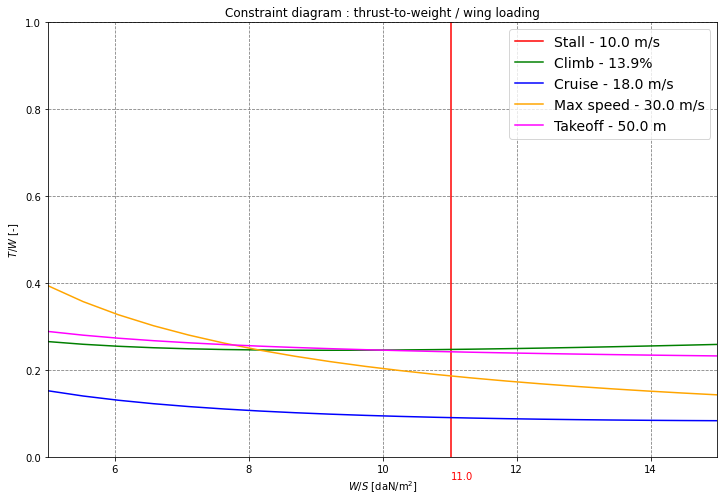

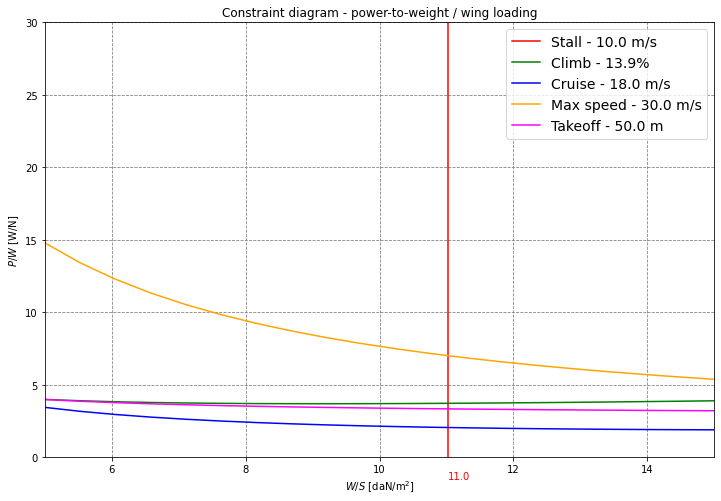

In [5]:
# DIAGRAMS
CONST_DIAG_THRUST_FLAG = 1
CONST_DIAG_POWER_FLAG = 1

plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '0.5'
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.marker'] = ''
plt.rcParams['legend.fontsize'] = 14


# constraint diagram for THRUST-to-weight ratio
if CONST_DIAG_THRUST_FLAG:
    fig = plt.figure(figsize=(12, 8))
    plt.title('Constraint diagram : thrust-to-weight / wing loading')
    ax = plt.gca()

    # STALL
    plt.plot([W_S_stall/10, W_S_stall/10], [T_W_range[0], T_W_range[-1]],\
        'r-', label=f'Stall - {V_s} m/s')
    plt.text(W_S_stall/10, -0.05*(T_W_range[-1]-T_W_range[0]), f'{W_S_stall/10:.1f}', color='r')

    # CLIMB
    plt.plot(W_S_range/10, T_W_climb, color='green', label=f'Climb - {100*climb_gradient:.1f}%')

    # CRUISE
    plt.plot(W_S_range/10, T_W_cruise, color='blue', label=f'Cruise - {V_cruise:.1f} m/s')

    # MAX SPEED
    plt.plot(W_S_range/10, T_W_vmax, color='orange', label=f'Max speed - {V_max:.1f} m/s')

    # TAKEOFF
    plt.plot(W_S_range/10, T_W_to, color='magenta', label=f'Takeoff - {takeoff_dist:.1f} m')


    # DIAGRAM PARAMETERS
    ax.legend()
    ax.set_xlabel('$W/S$ [daN/m${}^2$]')
    ax.set_ylabel('$T/W$ [-]')
    ax.set_xlim([W_S_range[0]/10, W_S_range[-1]/10])
    ax.set_ylim([T_W_range[0], T_W_range[-1]])
    plt.show()

# constraint diagram for POWER-to-weight ratio
if CONST_DIAG_POWER_FLAG:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.gca()
    plt.title('Constraint diagram - power-to-weight / wing loading')

    # STALL
    M_S_stall = W_S_stall/9.81
    plt.plot([W_S_stall/10, W_S_stall/10], [P_W_range[0], P_W_range[-1]],\
        'r-', label=f'Stall - {V_s} m/s')
    plt.text(W_S_stall/10, -0.05*(P_W_range[-1]-P_W_range[0]), f'{W_S_stall/10:.1f}', color='r')

    # CLIMB
    P_W_climb = T_W_climb * V_climb/prop_efficiency
    plt.plot(W_S_range/10, P_W_climb, color='green', label=f'Climb - {100*climb_gradient:.1f}%')

    # CRUISE
    P_W_cruise = T_W_cruise * V_cruise/prop_efficiency
    plt.plot(W_S_range/10, P_W_cruise, color='blue', label=f'Cruise - {V_cruise:.1f} m/s')

    # MAX SPEED
    P_W_vmax = T_W_vmax * V_max/prop_efficiency
    plt.plot(W_S_range/10, P_W_vmax, color='orange', label=f'Max speed - {V_max:.1f} m/s')

    # TAKEOFF
    P_W_to = T_W_to * V_to/prop_efficiency
    plt.plot(W_S_range/10, P_W_to, color='magenta', label=f'Takeoff - {takeoff_dist:.1f} m')


    # DIAGRAM PARAMETERS
    ax.legend()
    ax.set_xlabel('$W/S$ [daN/m${}^2$]')
    ax.set_ylabel('$P/W$ [W/N]')
    ax.set_xlim([W_S_range[0]/10, W_S_range[-1]/10])
    ax.set_ylim([P_W_range[0], P_W_range[-1]])
    plt.show()

Choix de W/S et T/S...

In [6]:
# wing loading (kg/m^2)
M_S = 11.2

# thrust-to-weight ratio (-)
#T_W = 0.65

# power-to-weight ratio (W/N)
P_W = 16.0

Initial sizing

In [7]:
# max takeoff weight range (kg)
MTOW = np.array([23, 24, 25])

#### WING PLANFORM ####
S_w = MTOW/M_S
print('S_w =', S_w)

b_w = np.sqrt(AR_w * S_w)
print('b_w =', b_w)

C_w = S_w / b_w
print('C_w = ', C_w)

C_L_cruise = MTOW*9.81/(0.5*rho_0*V_cruise**2*S_w)
print('C_L_c', C_L_cruise)

# Polhamus' formula
C_L_alpha_w = ( 2*np.pi*AR_w ) / (2 + np.sqrt( (AR_w/(C_l_alpha_w/2/np.pi))**2 + 4))
print('C_L_alpha = ', C_L_alpha_w)

# wing setting angle
# Naylor's theorem : the wing accounts for the totality of the lift
# HTP has 0 lift in cruise condition
delta_w = C_L_cruise/C_L_alpha_w + alpha_0_aerfoil
print('delta_w = ', np.rad2deg(delta_w) )


#### POWERPLANT ####
P_engine = P_W * MTOW * 9.81
print('P_engine =', P_engine/1000, 'kW')

S_w = [2.05357143 2.14285714 2.23214286]
b_w = [4.05321742 4.14039336 4.22577127]
C_w =  [0.50665218 0.51754917 0.52822141]
C_L_c [0.55365079 0.55365079 0.55365079]
C_L_alpha =  4.426548399972265
delta_w =  [4.16627289 4.16627289 4.16627289]
P_engine = [3.61008 3.76704 3.924  ] kW


In [8]:
V_cruise/prop_efficiency * (p_dyn_cruise*C_D_0/(12*9.81) + k_i_c/p_dyn_cruise * 12*9.81)

1.9966866363716698

### Payload

In [9]:
#dim_payload = [] # len